# Simple 1/V estimator
Source: doi:10.1093/mnras/stw756 (page 7)

## Imports, initial values

In [150]:
import numpy as np
from astropy.coordinates import Distance
from astropy.table import Table, hstack
from astropy.cosmology import Planck18
from astropy.coordinates import Distance
from astropy import units as u
import astropy.constants as asc
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import corner
import arviz as az

Complete Sky area in deg^2

In [2]:
omega_sky = 41253 #

In [3]:
min_ra = 160.0
min_dec = -8
max_ra = 180.0
max_dec = 2
buffer = 2.0

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 199.47 sqdeg


## Functions

define the functions that calculate the V_max & luminosity limit

In [4]:
def V_max(omega_s, z_min, z_max_lum):
    """
    Description: Calculates the maximum Volume in which the source could have been detected in: corrects for the so-called "Malmquist-bias"
    (faint objects, which usually also means low mass objects, will only be covered in a survey within a smaller volume than bright and high-mass
    objects)
    
    Params:
    omega_s: surface area covered by the complete data
    z_min: lower redshift limit of sample
    z_max_lum: maximum redshift determined for for object based on luminosity and its completeness 
    (i.e. maximum redshift at which the source with luminosity l would no longer be part of the sample)
    
    """
    z_max = min(z_max_data, z_max_lum)
    return 4/3*np.pi * omega_s/omega_sky * (Distance(z=z_max, cosmology=Planck18)**3-Distance(z=z_min, cosmology=Planck18)**3)

In [5]:
def lum_lim(lum, m_lim, m):
    """
    Calculate the luminosity a source would have if its magnitude was equal to the DESI magnitude limit (have to research the value)
    
    Params:
    - lum: luminosity of an object
    - m_lim: magnitude limit of the survey
    - m: apparent magnitude of an object
    
    """
    return lum*10**(-0.4*(m_lim-m))

## Load the data & prepare/select

In [6]:
# Release directory path

specprod = 'iron'    # Internal name for most current data release
specprod_dir = '/global/cfs/cdirs/desi/spectro/redux/iron/'
print(specprod_dir)

/global/cfs/cdirs/desi/spectro/redux/iron/


In [47]:
ztile_cat = Table.read(f'{specprod_dir}/zcatalog/zall-tilecumulative-{specprod}.fits', hdu="ZCATALOG")

In [292]:
ztile_cat[200000:200002]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_LIMIT_Z
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64
39627715262810453,main,bright,20220213,0.35847691976446494,0.00010889323413793392,0,GALAXY,179.60439511062276,-3.0788284618737713,2.246898,10.198668,23.088852,21.621041670441628,19.978641271591187,19.09149408340454,1.5856934736939618e+32,1.9840646425933075e+32
39627715262811960,main,bright,20220213,0.24140886669496137,1.1642882977903255e-05,0,GALAXY,179.67451767976064,-3.071761216748383,4.3009562,8.564695,13.837138,20.916087478399277,20.16822025179863,19.64738428592682,1.5668173852368463e+32,3.271229709067173e+32


In [787]:
ztile_cat.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'LASTNIGHT', 'SPECTYPE'])

In [512]:
ztile_cat = ztile_cat[ztile_cat["PROGRAM"] == "bright"]

In [513]:
len(ztile_cat)

228423

In [514]:
ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [515]:
ztile_cat = ztile_cat[ztile_cat['Z']>=0]

In [516]:
ztile_cat = ztile_cat[ztile_cat["FLUX_Z"] > 0.0]

In [517]:
ztile_cat = ztile_cat[ztile_cat["FLUX_R"] > 0.0]

In [518]:
ztile_cat = ztile_cat[ztile_cat["FLUX_G"] > 0.0]

In [519]:
ii = ztile_cat['TARGET_RA']>(min_ra)
ii &= ztile_cat['TARGET_RA']<(max_ra)
ii &= ztile_cat['TARGET_DEC']>(min_dec)
ii &= ztile_cat['TARGET_DEC']<(max_dec)

ztile_cat = ztile_cat[ii]

In [520]:
len(ztile_cat)

228423

In [521]:
ztile_cat = ztile_cat[ztile_cat["SPECTYPE"] == "GALAXY"]

In [522]:
len(ztile_cat)

228423

### Calculate the apparent and absolute magnitudes from the given Fluxes (app mag both r and z-band flux, to correct the z limit() with a Planck Cosmology

In [765]:
# calculate the absolute and apparent magnitude of every galaxy (Planck Cosmology)
app_mag_z = np.array([22.5-2.5*np.log10(ztile_cat["FLUX_Z"][q]) for q in range(len(ztile_cat["FLUX_Z"]))])
app_mag_r = np.array([22.5-2.5*np.log10(ztile_cat["FLUX_R"][q]) for q in range(len(ztile_cat["FLUX_R"]))])
app_mag_g = np.array([22.5-2.5*np.log10(ztile_cat["FLUX_G"][q]) for q in range(len(ztile_cat["FLUX_G"]))])

abs_mag_z = [(app_mag_z[q] - 5*np.log10(Distance(z=ztile_cat["Z"][q], cosmology=Planck18)/u.Mpc*10**6)+5).value for q in range(len(ztile_cat["FLUX_Z"]))]
abs_mag_r = [(app_mag_r[q] - 5*np.log10(Distance(z=ztile_cat["Z"][q], cosmology=Planck18)/u.Mpc*10**6)+5).value for q in range(len(ztile_cat["FLUX_R"]))]

In [524]:
corner_plot_data = {"G": app_mag_g, "R": app_mag_r, "Z": app_mag_z}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": app_mag_r>19.5})

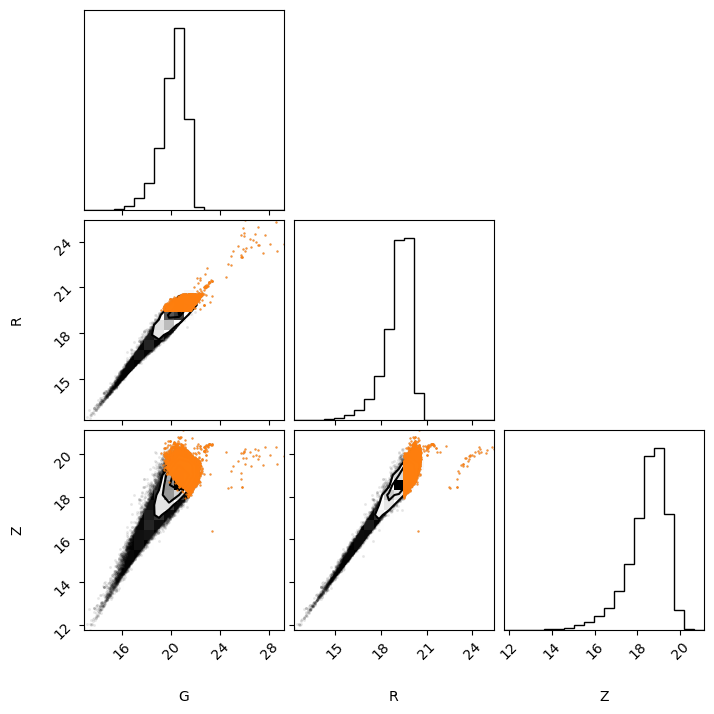

In [525]:
figure = corner.corner(corner_plot_data, divergences = True)

In [526]:
diff = [app_mag_r[q]-app_mag_z[q] for q in range(len(app_mag_r))]

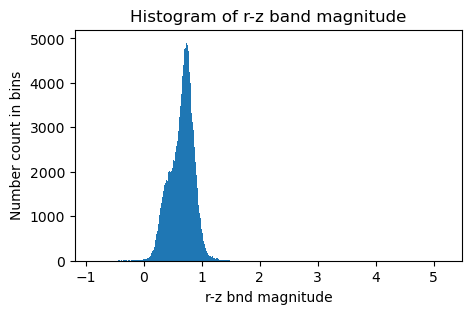

In [527]:
fig, ax = plt.subplots(figsize = (5,3))

ax.hist(diff, bins='auto')
ax.set_xlabel("r-z bnd magnitude")
ax.set_ylabel("Number count in bins")
plt.title("Histogram of r-z band magnitude")
plt.show()

In [528]:
avg_diff = np.mean(diff)

In [529]:
avg_diff

0.6518473640915409

In [763]:
# However, since we only look at the z-band we need to correct the solar luminosity
# Calculation from here: https://astronomy.stackexchange.com/questions/25126/how-to-calculate-luminosity-in-g-band-from-absolute-ab-magnitude-and-luminosity
lmbda_z = 920*10**(-9) #in  m
del_lambda_z = 160*10**(-9) #in m
del_v_z = (asc.c*lmbda_z/(del_lambda_z**2)).value # this is in /s now

lmbda_r = 640*10**(-9) #in  m 5600A-7200A -> 6400A median
del_lambda_r = 160*10**(-9) #in m
del_v_r = (asc.c*lmbda_r/(del_lambda_r**2)).value # this is in /s now


m_sun_z = -27.56 # in z-band: http://mips.as.arizona.edu/~cnaw/sun.html (DES filter)
m_sun_r = -27.12 # in r-band: http://mips.as.arizona.edu/~cnaw/sun.html (DES filter)

f_v_z = 10**((-48.6-m_sun_z)/2.5) # in erg/(cm^2 s Hz)
f_v_r = 10**((-48.6-m_sun_r)/2.5) # in erg/(cm^2 s Hz)

dist_sun = 1.496*10**13 # in cm

L_sun_z = f_v_z*del_v_z*4*np.pi*dist_sun**2 # this is  in erg/s, convert to W in function declaration
L_sun_r = f_v_r*del_v_r*4*np.pi*dist_sun**2
# the value is roughly half of the full bolometric value... not sure if this makes sense
print(L_sun_z, L_sun_r)

def lum_z(M):
    return L_sun_z*10**(-7)*np.exp(-0.4*M)*u.W

def lum_r(M):
    return L_sun_r*10**(-7)*np.exp(-0.4*M)*u.W

1.1626302434227456e+35 5.393041505438385e+34


# DO NOT CONTINUE WITHOUT CHANGING THE APP_MAG NAMES!!!

In [531]:
lums_z = [lum_z(abs_mag_z[q]).value for q in range(len(abs_mag_z))]

In [766]:
lums_r = [lum_r(abs_mag_r[q]).value for q in range(len(abs_mag_r))]

In [703]:
offset = 0

In [704]:
m_limit_z = 19.5-avg_diff+offset # r-band magnitude limit for BGS Bright, would need to convert it to z-band magnitude

In [705]:
m_limit_z

18.84815263590846

In [761]:
m_limit_r = 19.5

In [767]:
lumin_limits_r = [lum_lim(lums_r[q], m_limit_r, app_mag_r[q]) for q in range(len(ztile_cat["FLUX_R"]))]

In [706]:
lumin_limits_z = [lum_lim(lums_z[q], m_limit_z, app_mag_z[q]) for q in range(len(ztile_cat["FLUX_Z"]))]

In [707]:
# cornerplot (corner, chainconsumer) to see whether I miss peculiar galaxies
# redshift

In [788]:
ztile_cat = hstack([ztile_cat, Table({"APP_MAG_G": app_mag_g}),  Table({"APP_MAG_R": app_mag_r}), Table({'APP_MAG_Z': app_mag_z}), Table({"LUM_Z": lums_z}), Table({"LUM_R": lums_r}), Table({'LUM_LIMIT_Z': lumin_limits_z}), Table({'LUM_LIMIT_R': lumin_limits_r})])

In [789]:
ztile_cat

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627775337824625,main,bright,20211203,0.13764590720371164,3.138398346518236e-05,0,GALAXY,160.26516984509954,-0.6169891390880035,18.83545,51.795795,107.864204,19.312559962272644,18.2142636179924,17.417806386947632,6.005329560289285e+31,2.3223230433727233e+31,1.608415856803087e+31,7.106047050413164e+30
39627769298028466,main,bright,20211203,0.2817386734692243,3.1591015286591765e-05,0,GALAXY,160.32678007762797,-0.7009874345328915,4.700197,13.230762,27.53629,20.81970974802971,19.696037769317627,18.90023648738861,1.7622327585990123e+32,2.568494370351682e+31,1.84882928134987e+32,3.076760744541743e+31
39627775333634331,main,bright,20211203,0.13458266255484935,2.6267345434881147e-05,0,GALAXY,160.22171516984815,-0.6094808182128068,6.9386554,17.924074,42.162964,20.39681166410446,19.36640828847885,18.4376722574234,4.766014527359012e+31,1.4340282291044089e+31,3.265601677003487e+31,1.2680051457295532e+31
39627769298026862,main,bright,20211203,0.13299025612216608,7.00164724165495e-05,0,GALAXY,160.26156628507124,-0.7357844162293757,8.49183,20.583942,37.838287,20.177496820688248,19.21617865562439,18.555171191692352,5.670766484256024e+31,1.5058649533148656e+31,4.329614069608486e+31,1.1594645854182537e+31
39627787413227120,main,bright,20211203,0.13477296048907014,3.583645968152769e-06,0,GALAXY,160.07077291874026,-0.01671600137374464,21.668411,32.528183,43.264362,19.16043221950531,18.719350397586823,18.409674167633057,5.738129002661217e+31,1.8601220670733636e+31,3.8315890228061115e+31,9.06320083834694e+30
39627769298027878,main,bright,20211203,0.1919126971419605,2.206269425513075e-05,0,GALAXY,160.30116444104704,-0.6576801019874786,11.47951,32.69794,69.04125,19.850191473960876,18.713698983192444,17.902228236198425,7.674834731825541e+31,2.6116478036605993e+31,3.2114360065685273e+31,1.265884850934994e+31
39627769298027257,main,bright,20211203,0.13657319228018894,5.620423916466128e-05,0,GALAXY,160.27495064273108,-0.7181123946679159,7.617141,19.900192,38.26928,20.29552012681961,19.252856969833374,18.54287415742874,5.8801181807696835e+31,1.5215802923364019e+31,4.438892866575132e+31,1.211818735084446e+31
39627769293834545,main,bright,20211203,0.22811114966831142,2.5952989423481735e-05,0,GALAXY,160.10558163742888,-0.6667095058494888,3.2750242,7.7390156,14.049797,21.21196374297142,20.27828574180603,19.63082492351532,2.4883153197885885e+32,1.6521860587215142e+31,5.116515904197193e+32,3.383555074626688e+31
39627769298027769,main,bright,20211203,0.13891779011883018,2.0856369110834963e-05,0,GALAXY,160.2959805373684,-0.7673462975645843,4.0475388,8.019296,13.393776,20.982022434473038,20.239659398794174,19.68274235725403,7.32006080740643e+31,1.04194784689588e+31,1.578885285314624e+32,2.059253159918002e+31


In [790]:
ztile_cat_r_cut = ztile_cat[ztile_cat["APP_MAG_R"] < m_limit_r]

In [791]:
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]< 0.6]
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]> 0.1]

In [792]:
ztile_cat_r_cut = ztile_cat_r_cut[ztile_cat_r_cut["Z"] > 0.1]

In [793]:
z_max_data = np.max(ztile_cat_r_cut["Z"])
z_min_data = np.min(ztile_cat_r_cut["Z"])
print("z min and max in sample: ", z_min_data, z_max_data)

z min and max in sample:  0.10000133480204226 1.6972743730127822


In [794]:
ztile_cat_r_cut

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627775337824625,main,bright,20211203,0.13764590720371164,3.138398346518236e-05,0,GALAXY,160.26516984509954,-0.6169891390880035,18.83545,51.795795,107.864204,19.312559962272644,18.2142636179924,17.417806386947632,6.005329560289285e+31,2.3223230433727233e+31,1.608415856803087e+31,7.106047050413164e+30
39627775333634331,main,bright,20211203,0.13458266255484935,2.6267345434881147e-05,0,GALAXY,160.22171516984815,-0.6094808182128068,6.9386554,17.924074,42.162964,20.39681166410446,19.36640828847885,18.4376722574234,4.766014527359012e+31,1.4340282291044089e+31,3.265601677003487e+31,1.2680051457295532e+31
39627769298026862,main,bright,20211203,0.13299025612216608,7.00164724165495e-05,0,GALAXY,160.26156628507124,-0.7357844162293757,8.49183,20.583942,37.838287,20.177496820688248,19.21617865562439,18.555171191692352,5.670766484256024e+31,1.5058649533148656e+31,4.329614069608486e+31,1.1594645854182537e+31
39627787413227120,main,bright,20211203,0.13477296048907014,3.583645968152769e-06,0,GALAXY,160.07077291874026,-0.01671600137374464,21.668411,32.528183,43.264362,19.16043221950531,18.719350397586823,18.409674167633057,5.738129002661217e+31,1.8601220670733636e+31,3.8315890228061115e+31,9.06320083834694e+30
39627769298027878,main,bright,20211203,0.1919126971419605,2.206269425513075e-05,0,GALAXY,160.30116444104704,-0.6576801019874786,11.47951,32.69794,69.04125,19.850191473960876,18.713698983192444,17.902228236198425,7.674834731825541e+31,2.6116478036605993e+31,3.2114360065685273e+31,1.265884850934994e+31
39627769298027257,main,bright,20211203,0.13657319228018894,5.620423916466128e-05,0,GALAXY,160.27495064273108,-0.7181123946679159,7.617141,19.900192,38.26928,20.29552012681961,19.252856969833374,18.54287415742874,5.8801181807696835e+31,1.5215802923364019e+31,4.438892866575132e+31,1.211818735084446e+31
39627769293836999,main,bright,20211203,0.28314743112105445,5.270605778728687e-05,0,GALAXY,160.20747811643687,-0.7398594651345043,5.2359915,20.66519,43.343533,20.702502727508545,19.211901426315308,18.407689332962036,7.307656946753363e+31,3.132833339371409e+31,4.870716254430721e+31,2.402690672463901e+31
39627787413226785,main,bright,20211203,0.13377130957504585,5.181663556964667e-06,0,GALAXY,160.0562153862003,-0.10595802403019254,12.539079,19.833014,27.650469,19.75433588027954,19.256528317928314,18.895743787288666,4.076150641492417e+31,1.4899498436987025e+31,4.258794517555474e+31,1.190646874159722e+31
39627787413228010,main,bright,20211203,0.1391012047609144,5.262625606954963e-05,0,GALAXY,160.10640563198723,-0.1189626488410825,10.3892,27.175236,51.205555,19.958544671535492,18.91456663608551,18.22670727968216,1.4456633790032276e+32,1.772471485495844e+31,8.156221984637498e+31,1.0337271234641149e+31


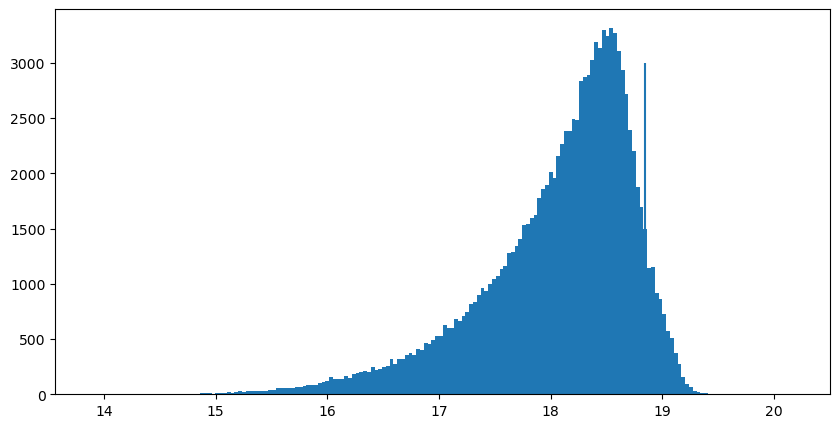

In [795]:
fig, ax = plt.subplots(figsize = (10,5))

ax.hist(ztile_cat_r_cut["APP_MAG_Z"], bins = "auto")
ax.vlines(m_limit_z, 0, 3000)

plt.show()

In [796]:
corner_plot_data = {"G": ztile_cat_r_cut["APP_MAG_G"], "R": ztile_cat_r_cut["APP_MAG_R"], "Z": ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

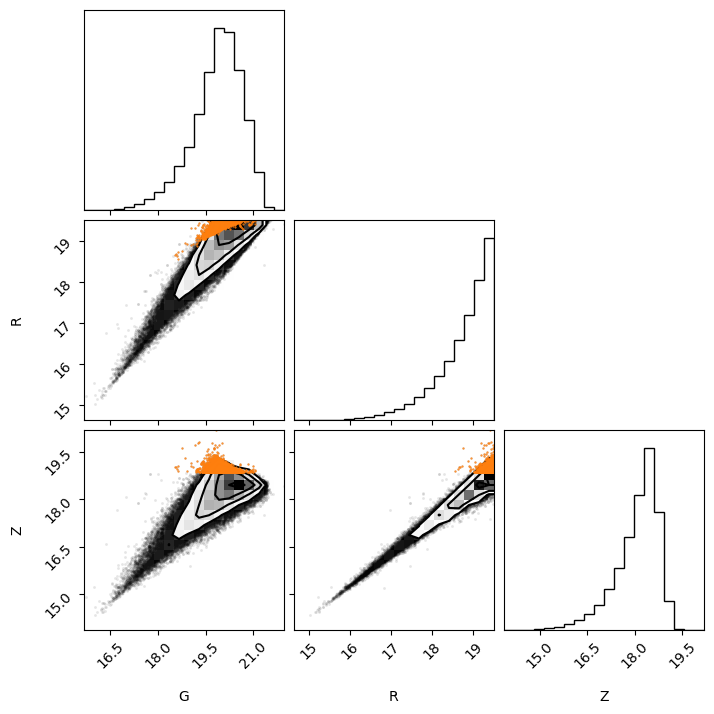

In [797]:
figure = corner.corner(corner_plot_data, divergences = True)

In [798]:
corner_plot_data = {"G-R": ztile_cat_r_cut["APP_MAG_G"]-ztile_cat_r_cut["APP_MAG_R"], "R-Z": ztile_cat_r_cut["APP_MAG_R"] - ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

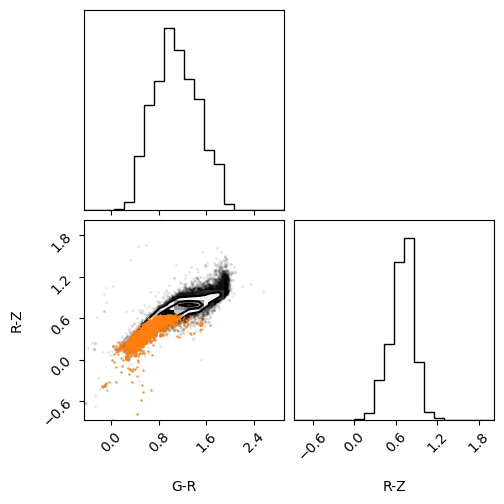

In [799]:
figure = corner.corner(corner_plot_data, divergences = True)

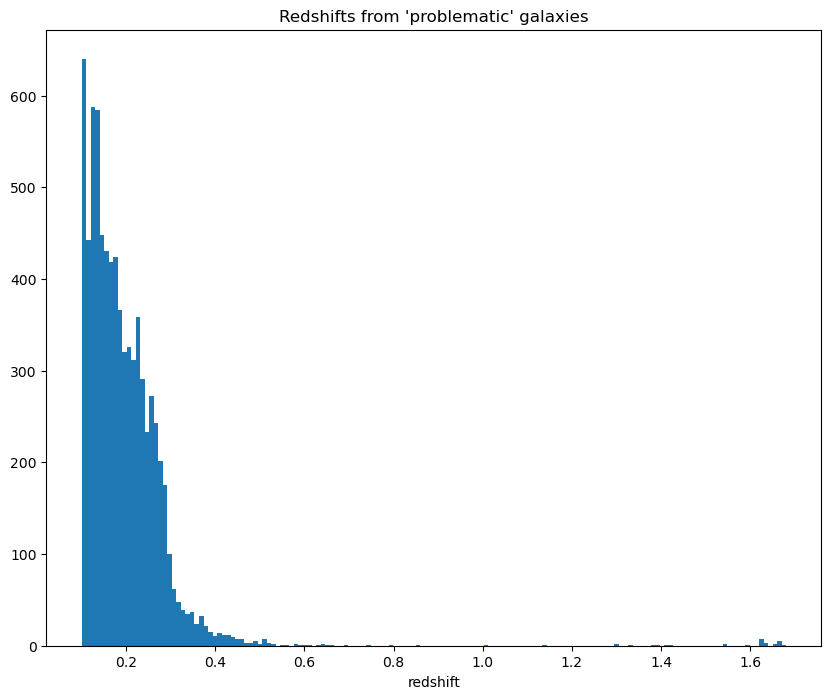

In [800]:
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(ztile_cat_r_cut["Z"][ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z], bins = "auto")
ax.set_xlabel("redshift")
plt.title("Redshifts from 'problematic' galaxies")
plt.show()

In [801]:
len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z]), len(ztile_cat_r_cut), len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z])/len(ztile_cat_r_cut)

(7633, 116476, 0.06553281362684159)

In [802]:
ztile_cat_grouped_by_AppMag = ztile_cat_r_cut.group_by("APP_MAG_R")

In [803]:
ztile_cat_grouped_by_AppMag

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627781692196799,sv3,bright,20210501,0.10747144463925516,1.818968440523567e-05,0,GALAXY,179.08357626336823,-0.20556252174575723,541.38214,1389.6007,2806.7297,15.666240453720093,14.642775058746338,13.87949824333191,4.0510917900583374e+31,7.686074466253902e+31,4.169752968694398e+29,8.766265328262862e+29
39627799668986847,main,bright,20220212,0.1006116447293789,1.8389733472447712e-05,0,GALAXY,170.68695580001403,0.4622516854532926,397.39447,964.94586,1790.3483,16.001945734024048,15.038742423057556,14.367656111717224,2.83055857533244e+31,6.170685343013916e+31,4.5674472137708044e+29,1.0135154432495418e+30
39627696866593362,main,bright,20220312,0.10787162036977999,1.732253838084697e-05,0,GALAXY,161.8435959282249,-3.7522345991569006,367.48782,867.08966,1656.368,16.08689248561859,15.154839754104614,14.452108144760132,4.14163645154433e+31,6.284210662073203e+31,7.223608125800038e+29,1.148647143409073e+30
39627654869030068,main,bright,20220213,0.11658788477000842,2.652876814398194e-05,0,GALAXY,172.70212038918515,-5.546945014914002,318.821,841.4778,1642.8849,16.241132616996765,15.187393426895142,14.460982084274292,1.0714196282734836e+32,6.668793575711219e+31,1.884045460140554e+30,1.256043398611351e+30
39627835937129473,main,bright,20220329,0.10964324775449051,2.4118651038848044e-05,0,GALAXY,172.29901340133625,1.9960480131734615,331.49387,825.2125,1552.931,16.198811531066895,15.208585262298584,14.522119760513306,8.420816729413487e+31,6.244480536185685e+31,1.56653847308893e+30,1.1993071453870628e+30
39627636892239451,main,bright,20211212,1.150921868512021,8.693763568456872e-05,0,GALAXY,176.31080202398348,-6.2916661793181765,516.65674,820.00757,1079.5172,15.716995000839233,15.215455293655396,14.9169260263443,7.668513188055362e+32,6.688583213002297e+32,2.0522039773307973e+31,1.2927550768242197e+31
39627715157952077,main,bright,20220212,0.11734826220185841,1.9543843638868422e-05,0,GALAXY,173.3306204195519,-3.0137298050366828,329.50845,815.9549,1505.5103,16.205333471298218,15.220834612846375,14.555790424346924,1.331180088102601e+32,6.6202687851422415e+31,2.5544177783230316e+30,1.2859067245587066e+30
39627690965208223,main,bright,20220402,0.10369683442097574,1.9161701506552776e-05,0,GALAXY,169.65030677576536,-4.0977914279114325,313.59595,802.2161,1536.7024,16.259073615074158,15.239271521568298,14.533525705337524,4.251813019785421e+31,5.856792965503464e+31,7.993249795872045e+29,1.1570935717126344e+30
39627721256472139,main,bright,20220307,0.12281163842735825,2.461482370244118e-06,0,GALAXY,176.91221065267374,-2.8240357970076695,397.9955,802.09326,1440.4661,16.00030481815338,15.239437818527222,14.603742361068726,4.686854888431462e+31,6.857033628855034e+31,9.399773686234379e+29,1.3549129908310573e+30


In [804]:
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[::-1]

In [805]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,1.1895318260913294e+32,2.3153667790664683e+31,1.4470028092243428e+32,2.315341103233412e+31
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,1.672930381959732e+32,1.9997272057678025e+31,2.071988081002479e+32,1.9996946011249012e+31
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,1.160590902253323e+32,2.0638592496609297e+31,9.860670415028487e+31,2.0638040725425263e+31
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,2.088771778725142e+32,2.1028425950715283e+31,1.8441242056620207e+32,2.102730388775235e+31
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1254667879231068e+32,1.369813393580596e+31,1.4751887124999046e+32,1.36973278167297e+31


In [806]:
ztile_cat_grouped_by_AppMag_sel = ztile_cat_grouped_by_AppMag[:int(0.2*len(ztile_cat_grouped_by_AppMag))]

In [807]:
np.max(ztile_cat_grouped_by_AppMag["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag["LUM_R"]), np.max(ztile_cat_grouped_by_AppMag_sel["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag_sel["LUM_R"])

(6.688583213002297e+32,
 1.0340261090297606e+31,
 1.916684190000783e+32,
 1.0340261090297606e+31)

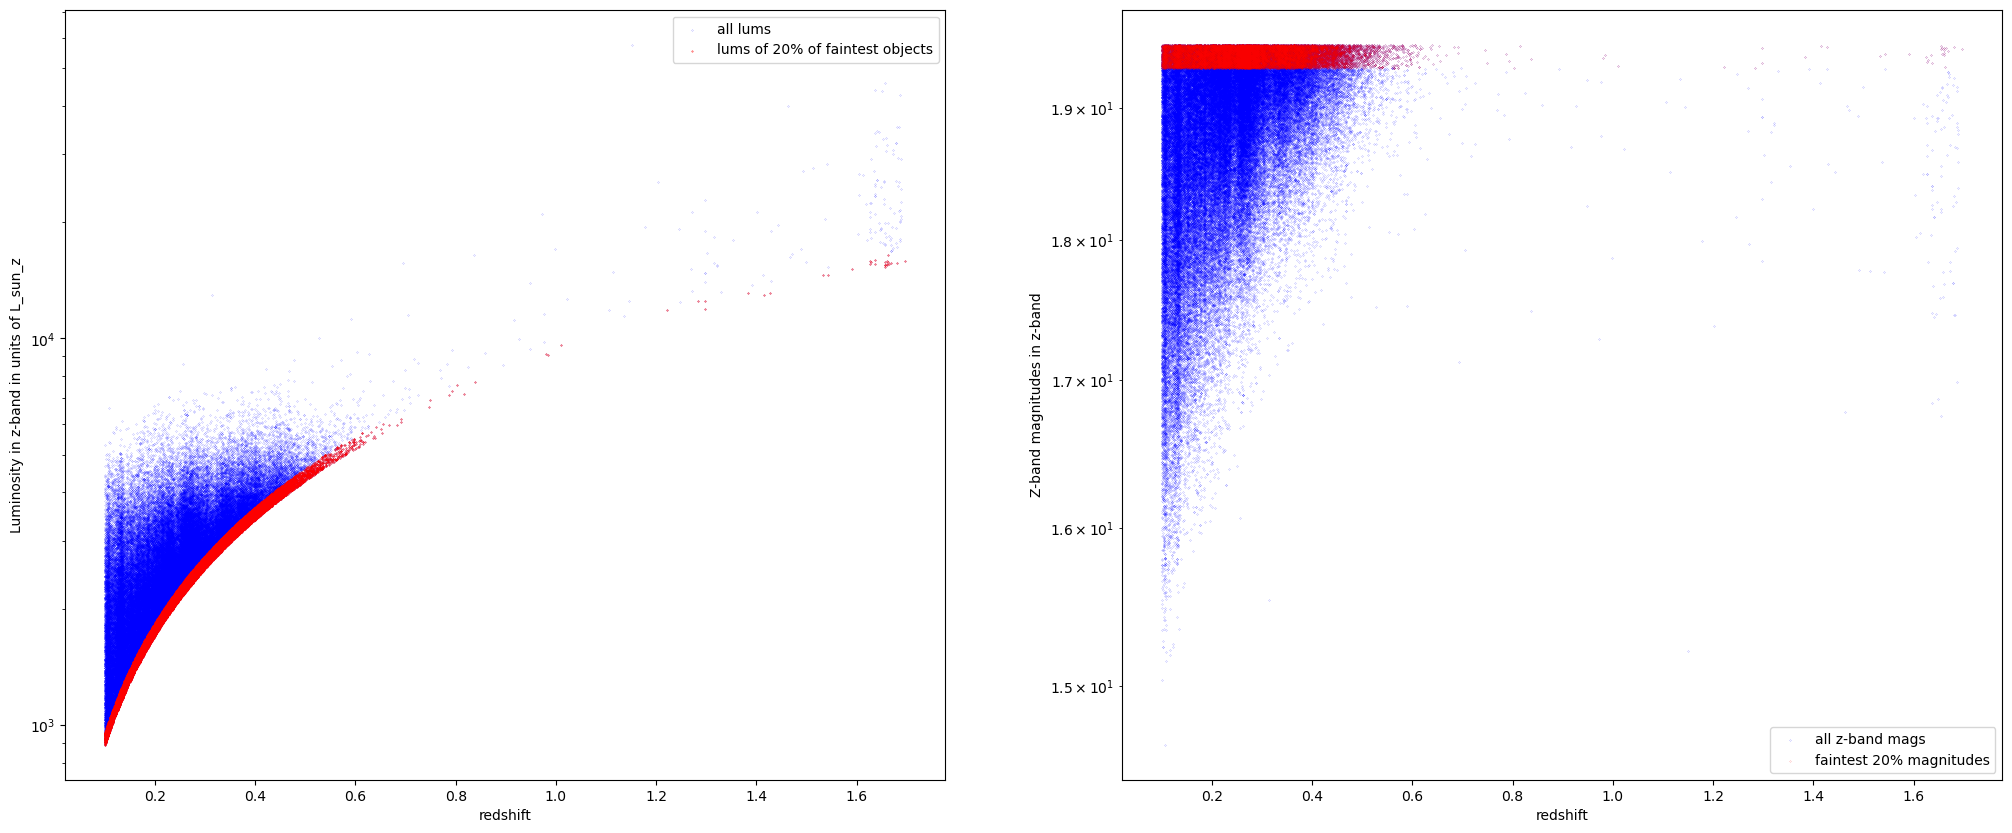

In [831]:
fig, ax = plt.subplots(ncols = 2, figsize = (25,10))

ax[0].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), s = 0.01, color = "blue", label = "all lums")
ax[0].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/(L_sun_r*10**(-7)), s = 0.1, color = "red", label ="lums of 20% of faintest objects")

ax[1].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["APP_MAG_R"], s = 0.01, color = "blue", label = "all r-band mags")
ax[1].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["APP_MAG_R"], s = 0.01, color = "red", label = "faintest 20% magnitudes")


ax[0].set_xlabel("redshift")
ax[0].set_ylabel("Luminosity in r-band in units of L_sun_r")
ax[0].set_yscale("log")
#ax.set_xlim(0.08,.6)
#ax.set_ylim(10**3,10**5)
ax[0].legend()

ax[1].set_xlabel("redshift")
ax[1].set_ylabel("Z-band magnitudes in r-band")
ax[1].set_yscale("log")
ax[1].legend()

plt.show()

In [833]:
ztile_cat_grouped_by_AppMag_sel

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,1.1895318260913294e+32,2.3153667790664683e+31,1.4470028092243428e+32,2.315341103233412e+31
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,1.672930381959732e+32,1.9997272057678025e+31,2.071988081002479e+32,1.9996946011249012e+31
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,1.160590902253323e+32,2.0638592496609297e+31,9.860670415028487e+31,2.0638040725425263e+31
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,2.088771778725142e+32,2.1028425950715283e+31,1.8441242056620207e+32,2.102730388775235e+31
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1254667879231068e+32,1.369813393580596e+31,1.4751887124999046e+32,1.36973278167297e+31
39627751249939488,main,bright,20211219,0.17741879029265198,4.038567067795509e-06,0,GALAXY,164.62507716662276,-1.4904943931161718,7.6938553,15.849929,28.825605,20.28463989496231,19.499931633472443,18.850553929805756,5.830765014222413e+31,1.7680456257158949e+31,5.843675033290737e+31,1.7679342991027484e+31
39627678826889600,main,bright,20220202,0.27617559570485434,5.8314291574574656e-05,0,GALAXY,164.7234944064917,-4.579779678579022,4.7597575,15.850132,34.427982,20.806037932634354,19.49991762638092,18.657720983028412,1.1553503643060075e+32,2.723566015483503e+31,9.694848894232211e+31,2.7233593893452795e+31
39627805838803573,sv3,bright,20210412,0.22758025299510903,0.00013580970085046507,0,GALAXY,178.28342115643846,0.7625343731361771,4.905727,15.850238,32.08448,20.77324151992798,19.499910473823547,18.734262585639954,1.0073795215220841e+32,2.2505390579797125e+31,9.070622605614431e+31,2.250353493706005e+31
39627805838803573,main,bright,20220515,0.22737522444350716,6.494913995492875e-05,0,GALAXY,178.28342115643846,0.7625343731361771,4.905727,15.850238,32.08448,20.77324151992798,19.499910473823547,18.734262585639954,6.338787967103921e+31,2.24855565159427e+31,5.707556308047214e+31,2.248370250858877e+31


In [834]:
lower_limit_z = np.min(ztile_cat_grouped_by_AppMag["Z"]) # np.min(faint_mags["Z"]) # get the limits of redshift in this sample
upper_limit_z = np.max(ztile_cat_grouped_by_AppMag["Z"]) # np.max(faint_mags["Z"])
delta_z = 0.005
bins = np.arange(lower_limit_z, upper_limit_z, delta_z)
num_of_bins_z = len(bins)

In [835]:
lower_limit_z, upper_limit_z, num_of_bins_z

(0.10000133480204226, 1.6972743730127822, 320)

In [836]:
LUM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin
LUM_LIM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin

cnt = 0
for bins_left_edge in bins[:num_of_bins_z-1]:
    # this is where we select all the galaxies that lie in the z range ([start, stop))
    
    # z-range selection
    ii = ztile_cat_grouped_by_AppMag_sel['Z']>=(bins_left_edge)
    ii &= ztile_cat_grouped_by_AppMag_sel['Z']<(bins_left_edge+delta_z)
    dat = ztile_cat_grouped_by_AppMag_sel[ii]

    # select only z-band luminosity (limit)
    LUM = dat["LUM_R"]
    LUM_LIM = dat["LUM_LIMIT_R"]
    
    # sort this data ascending
    LUM = np.sort(LUM)
    LUM_LIM = np.sort(LUM_LIM)
    
    # impose the same cut as in the paper, at 95%. This is the mass limit value
    LUM_cut = int(0.95*len(LUM))
    LUM_LIM_cut = int(0.95*len(LUM_LIM))

    # if there was no data in this bin, just store a 0
    if len(LUM) == 0:
        LUM = [0]
    if len(LUM_LIM) == 0:
        LUM_LIM = [0]
    
    # now store this luminosity (limit) value for the whole redshift range
    LUM_95[cnt] = LUM[LUM_cut] # this is the 95% lum per bin
    LUM_LIM_95[cnt] = LUM_LIM[LUM_LIM_cut] # this is the "Luminosity Limit" value per bin
    cnt += 1

In [837]:
stop_at = np.argmin(LUM_LIM_95[10:])
if stop_at == 0:
    stop_at = len(LUM_LIM_95)

In [838]:
stop_at

95

Fit values:  2444.127680079617 16736.14497095199 223.55868940159365


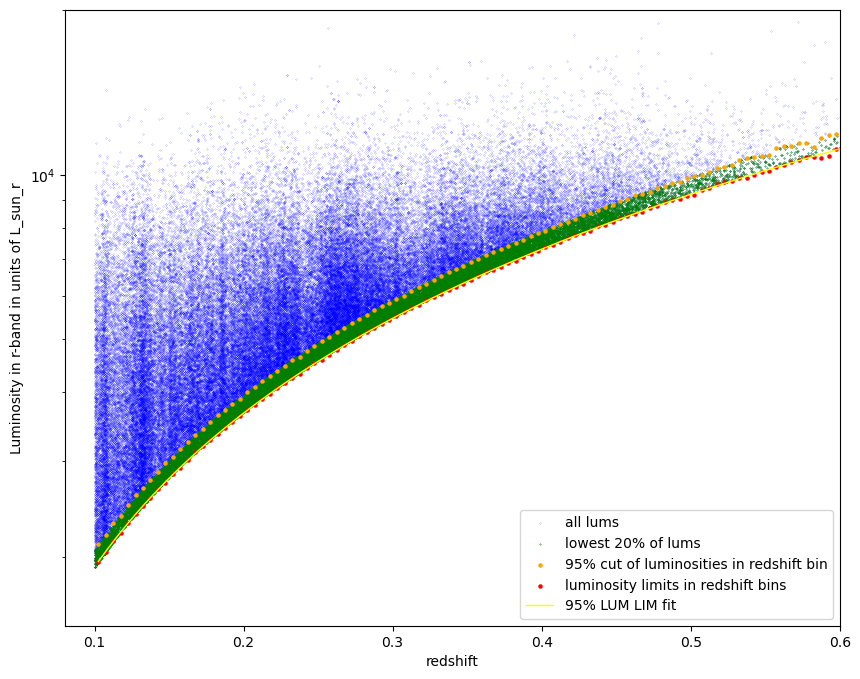

In [875]:
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), s = 0.01, color = "blue", label = "all lums")
ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/(L_sun_r*10**(-7)), s = 0.1, color = "green", label ="lowest 20% of lums")

center_z = (bins[:-1] + bins[1:])/2
ax.scatter(center_z, LUM_95/(L_sun_r*10**(-7)), s = 5, color = "orange", label = "95% cut of luminosities in redshift bin")
ax.scatter(center_z, LUM_LIM_95/(L_sun_r*10**(-7)), s = 5, color = "red", label ="luminosity limits in redshift bins")

def poly2d(x, a, b, c):
    return a*x**2 + b*x + c

coefs_LUM_LIM_95, _ = curve_fit(poly2d, center_z[:int(stop_at)], LUM_LIM_95[:int(stop_at)]/(L_sun_r*10**(-7)))
print("Fit values: ", coefs_LUM_LIM_95[0], coefs_LUM_LIM_95[1], coefs_LUM_LIM_95[2])

ax.plot(center_z, poly2d(center_z, *coefs_LUM_LIM_95), linewidth = 1, color = "yellow", label = "95% LUM LIM fit")

ax.set_xlabel("redshift")
ax.set_ylabel("Luminosity in r-band in units of L_sun_r")
ax.set_yscale("log")
ax.set_xlim(0.08,.6)
ax.set_ylim(1.5*10**3,2*10**4)
ax.legend()
plt.show()

invert to get zmax

$$ax^2+bx+c = a(x-h)^2+k$$ with $$h = -\frac{b}{2a} \text{ and } k = c-ah^2$$

i.e. the inverse of a quadratic is:

$$ f^{-1}(x) = \pm\sqrt{\frac{x-k}{a}}+h$$

To reproduce the physically correct results one has to take the negative solution!

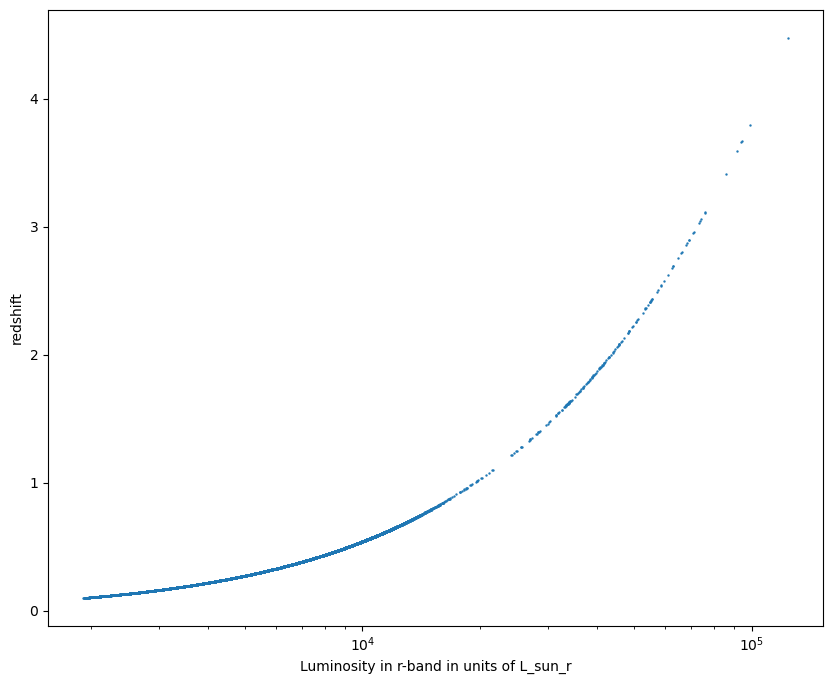

In [877]:
# now plot the inverse:

# from here we can get the z_max values, i.e. the maximum redshift at a certain luminosity that an object could be detected

# inverse is as above

def poly_inverse(x, a,h,k):
    return np.sqrt((x-k)/a)+h

a = coefs_LUM_LIM_95[0]
b = coefs_LUM_LIM_95[1]
c = coefs_LUM_LIM_95[2]
h = -b/(2*a)
k = c-a*h**2
inverted_coefs_95 = [a,h,k]

fig, ax = plt.subplots(figsize = (10,8))

#ax.scatter(LUM_LIM_95/(L_sun_z*10**(-7)), center_z, s = 3, color = "red", label ="Calculated luminosity limits, including a offseted z-band magnitude limit")

ax.scatter(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), poly_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), *inverted_coefs_95), s = 0.5)
#ax.vlines(LUM_LIM_95[stop_at-1]/(L_sun_z*10**(-7)), 0, 1, label = "limit of fit")


ax.set_xlabel("Luminosity in r-band in units of L_sun_r")
ax.set_ylabel("redshift")
ax.set_xscale("log")
#ax.set_ylim(0,1)
#ax.set_xlim(10,10**5)
#ax.legend()
plt.show()

In [878]:
z_max_i = np.array(poly_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), *inverted_coefs_95))

In [879]:
z_max_i[:5], len(ztile_cat_grouped_by_AppMag)

(array([0.23509611, 0.20222492, 0.20892781, 0.21299619, 0.13571745]), 116476)

In [880]:
ztile_cat_z_max = hstack([ztile_cat_grouped_by_AppMag, Table({"z_max": z_max_i})])

In [881]:
ztile_cat_z_max[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,1.1895318260913294e+32,2.3153667790664683e+31,1.4470028092243428e+32,2.315341103233412e+31,0.23509610627913924
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,1.672930381959732e+32,1.9997272057678025e+31,2.071988081002479e+32,1.9996946011249012e+31,0.20222491979798995
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,1.160590902253323e+32,2.0638592496609297e+31,9.860670415028487e+31,2.0638040725425263e+31,0.20892780656409204
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,2.088771778725142e+32,2.1028425950715283e+31,1.8441242056620207e+32,2.102730388775235e+31,0.2129961904520603
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1254667879231068e+32,1.369813393580596e+31,1.4751887124999046e+32,1.36973278167297e+31,0.13571744684641063


In [882]:
#only allow redshifts above 0.1
ztile_cat_z_max = ztile_cat_z_max[ztile_cat_z_max["z_max"] >0.1]

In [883]:
ztile_cat_z_max[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,1.1895318260913294e+32,2.3153667790664683e+31,1.4470028092243428e+32,2.315341103233412e+31,0.23509610627913924
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,1.672930381959732e+32,1.9997272057678025e+31,2.071988081002479e+32,1.9996946011249012e+31,0.20222491979798995
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,1.160590902253323e+32,2.0638592496609297e+31,9.860670415028487e+31,2.0638040725425263e+31,0.20892780656409204
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,2.088771778725142e+32,2.1028425950715283e+31,1.8441242056620207e+32,2.102730388775235e+31,0.2129961904520603
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1254667879231068e+32,1.369813393580596e+31,1.4751887124999046e+32,1.36973278167297e+31,0.13571744684641063


In [884]:
np.min(ztile_cat_z_max["Z"]), np.max(ztile_cat_z_max["Z"])

(0.10000133480204226, 1.6972743730127822)

In [885]:
V_max_i = [V_max(area, z_min_data, ztile_cat_z_max["z_max"][q]) for q in range(len(ztile_cat_z_max))]

In [886]:
len(V_max_i)

116474

In [887]:
len(ztile_cat_z_max)

116474

In [888]:
V_max_i[:5]

[<Quantity 34025682.32841531 Mpc3>,
 <Quantity 19620946.08353875 Mpc3>,
 <Quantity 22139597.97457696 Mpc3>,
 <Quantity 23767369.81380876 Mpc3>,
 <Quantity 3663269.75344565 Mpc3>]

In [889]:
ztile_wVmax = hstack([ztile_cat_z_max, Table({"V_MAX": V_max_i})])

In [890]:
ztile_wVmax

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,V_MAX
,,,,,,,,,,,,,,,,,,,,,Mpc3
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,1.1895318260913294e+32,2.3153667790664683e+31,1.4470028092243428e+32,2.315341103233412e+31,0.23509610627913924,34025682.32841531
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,1.672930381959732e+32,1.9997272057678025e+31,2.071988081002479e+32,1.9996946011249012e+31,0.20222491979798995,19620946.083538752
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,1.160590902253323e+32,2.0638592496609297e+31,9.860670415028487e+31,2.0638040725425263e+31,0.20892780656409204,22139597.97457696
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,2.088771778725142e+32,2.1028425950715283e+31,1.8441242056620207e+32,2.102730388775235e+31,0.2129961904520603,23767369.813808758
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1254667879231068e+32,1.369813393580596e+31,1.4751887124999046e+32,1.36973278167297e+31,0.13571744684641063,3663269.7534456495
39627751249939488,main,bright,20211219,0.17741879029265198,4.038567067795509e-06,0,GALAXY,164.62507716662276,-1.4904943931161718,7.6938553,15.849929,28.825605,20.28463989496231,19.499931633472443,18.850553929805756,5.830765014222413e+31,1.7680456257158949e+31,5.843675033290737e+31,1.7679342991027484e+31,0.17790633252865407,12044039.125754884
39627678826889600,main,bright,20220202,0.27617559570485434,5.8314291574574656e-05,0,GALAXY,164.7234944064917,-4.579779678579022,4.7597575,15.850132,34.427982,20.806037932634354,19.49991762638092,18.657720983028412,1.1553503643060075e+32,2.723566015483503e+31,9.694848894232211e+31,2.7233593893452795e+31,0.27717368798077713,61292817.35737782
39627805838803573,sv3,bright,20210412,0.22758025299510903,0.00013580970085046507,0,GALAXY,178.28342115643846,0.7625343731361771,4.905727,15.850238,32.08448,20.77324151992798,19.499910473823547,18.734262585639954,1.0073795215220841e+32,2.2505390579797125e+31,9.070622605614431e+31,2.250353493706005e+31,0.22836899112884979,30638102.042896647


In [917]:
lower_limit_lum = np.min(ztile_wVmax["LUM_R"])
upper_limit_lum = np.max(ztile_wVmax["LUM_R"])
print("lower and upper limit of LUM_R: ", lower_limit_lum, upper_limit_lum)

num_of_lum_bins = 100

lum_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), num_of_lum_bins, endpoint = True)

print("num of bins", len(lum_bins))
print(lum_bins[0:10])

lower and upper limit of LUM_R:  1.0365870057708868e+31 6.688583213002297e+32
num of bins 100
[1.03658701e+31 1.08114973e+31 1.12762820e+31 1.17610478e+31
 1.22666535e+31 1.27939952e+31 1.33440072e+31 1.39176642e+31
 1.45159825e+31 1.51400225e+31]


In [918]:
len(lum_bins)

100

In [919]:
def calc_phi_j(V_max_i, lum_bins):
    
    phi_j = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        one_ov_dat = [1/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

In [920]:
phi_j = calc_phi_j(V_max_i, lum_bins)

In [921]:
len(phi_j)

99

In [922]:
phi_j[:5]

[0.0008079923954250956,
 0.0005134335344275699,
 0.0004112725205377263,
 0.00032409898806769546,
 0.00029636925405885717]

In [923]:
center_lum_bins = lum_bins[1:]-lum_bin_size/2

In [924]:
len(center_lum_bins)

99

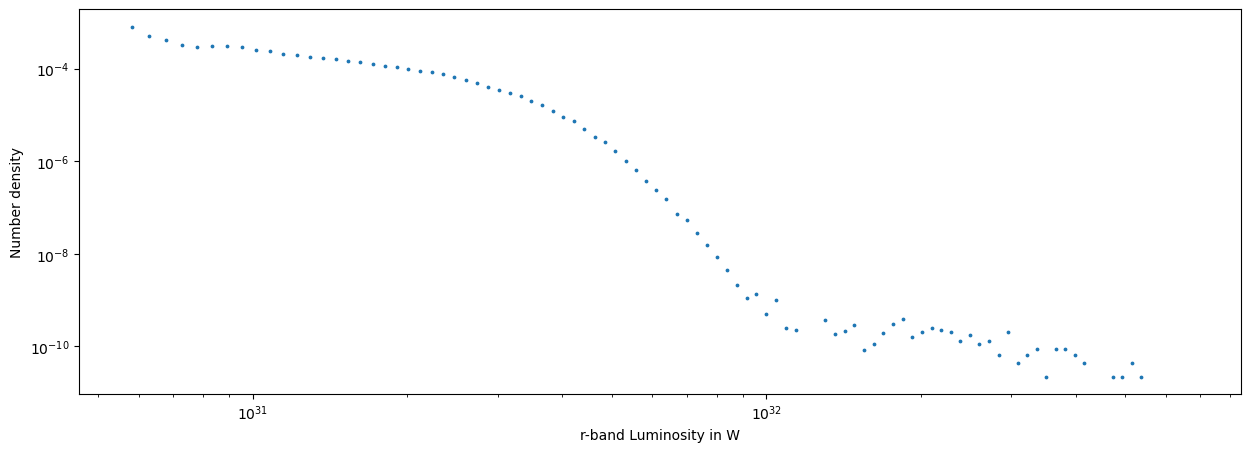

In [925]:
fig, ax = plt.subplots(figsize = (15,5))

ax.scatter(center_lum_bins, phi_j, s = 3)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")

plt.show()